# Previsão de Vendas: Impacto de Investimento em Marketing

O objetivo central deste estudo é prever o volume de vendas com base nos investimentos em diferentes canais de comunicação. O foco metodológico consiste na avaliação comparativa de diferentes algoritmos de regressão e na análise de sinergia entre as mídias para identificar o modelo mais promissor e os fatores que mais impulsionam o ROI (Retorno sobre Investimento).

### Fonte dos Dados
O conjunto de dados contém registros de investimentos e vendas de 200 casos e foi obtido através do Kaggle:
* **Dataset:** [Advertising Dataset](https://www.kaggle.com/datasets/ashydv/advertising-dataset)
* **Alvo (Target):** `Sales` (Valor final em milhares de unidades vendidas).

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [27]:
df = pd.read_csv('../data/raw/advertising.csv')

In [28]:
df = df.fillna(df.median())

### Análise Exploratória de Dados (EDA)

Antes de modelar, precisamos entender as relações entre as variáveis. O mapa de calor de correlação nos permite identificar quais canais (TV, Radio, Newspaper) possuem maior força de associação com as vendas.

In [29]:
def perform_eda(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlação entre Variáveis")
    plt.show()

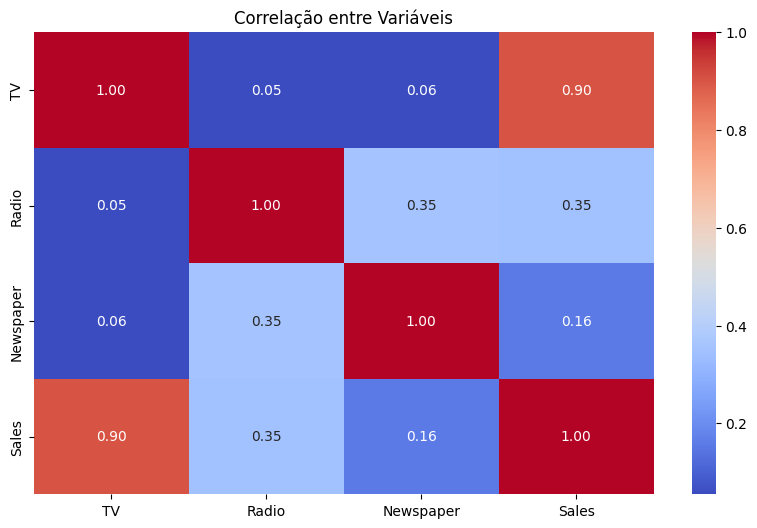

In [30]:
perform_eda(df)

### Divisão e Estratégia de Validação

Separamos os dados em conjuntos de Treino (70%) e Teste (30%). O conjunto de teste será nossa "prova real", usado apenas para a avaliação final de métricas que o modelo nunca viu.

In [ ]:
X = df.drop('Sales', axis=1)
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Engenharia de Features e Definição de Modelos

Utilizamos Pipelines para encadear três processos fundamentais:
- PolynomialFeatures: Cria termos de interação (ex: TV × Radio) para capturar sinergias que modelos lineares simples ignorariam.

- StandardScaler: Normaliza as escalas, garantindo que o modelo não dê peso indevido a uma variável apenas pela sua magnitude numérica.

- Modelagem: Comparamos a Regressão Linear, Random Forest e XGBoost.

Aplicamos o GridSearchCV para realizar uma Validação Cruzada (5-fold), testando diferentes combinações de hiperparâmetros para encontrar a configuração ótima de cada algoritmo.

In [32]:
pipelines = {
    'Linear_Regression': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('scaler', StandardScaler()),
        ('reg', Ridge())
    ]),
    'Random_Forest': Pipeline([
        ('reg', RandomForestRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('reg', XGBRegressor(random_state=42))
    ])
}

In [33]:
params = {
    'Linear_Regression': {'reg__alpha': [0.1, 1.0, 10.0]},
    'Random_Forest': {
        'reg__n_estimators': [50, 100, 200],
        'reg__max_depth': [None, 10, 20]
    },
    'XGBoost': {
        'reg__n_estimators': [100, 200],
        'reg__learning_rate': [0.01, 0.1],
        'reg__max_depth': [3, 5]
    }
}

In [34]:
results = {}

### Avaliação e Comparação de Performance

Após o treinamento, comparamos os modelos utilizando duas métricas fundamentais para regressão: 
- $R^2$ (Coeficiente de Determinação): Indica quanto da variação das vendas é explicada pelo modelo. 
- $RMSE$ (Erro Quadrático Médio): Indica o erro médio das previsões na mesma unidade das vendas.

C:\Users\Carlos Eduardo\AppData\Local\Temp\ipykernel_18408\3514948810.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=df_plot, ax=ax1, palette='Blues_d')
C:\Users\Carlos Eduardo\AppData\Local\Temp\ipykernel_18408\3514948810.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=df_plot, ax=ax2, palette='Reds_d')


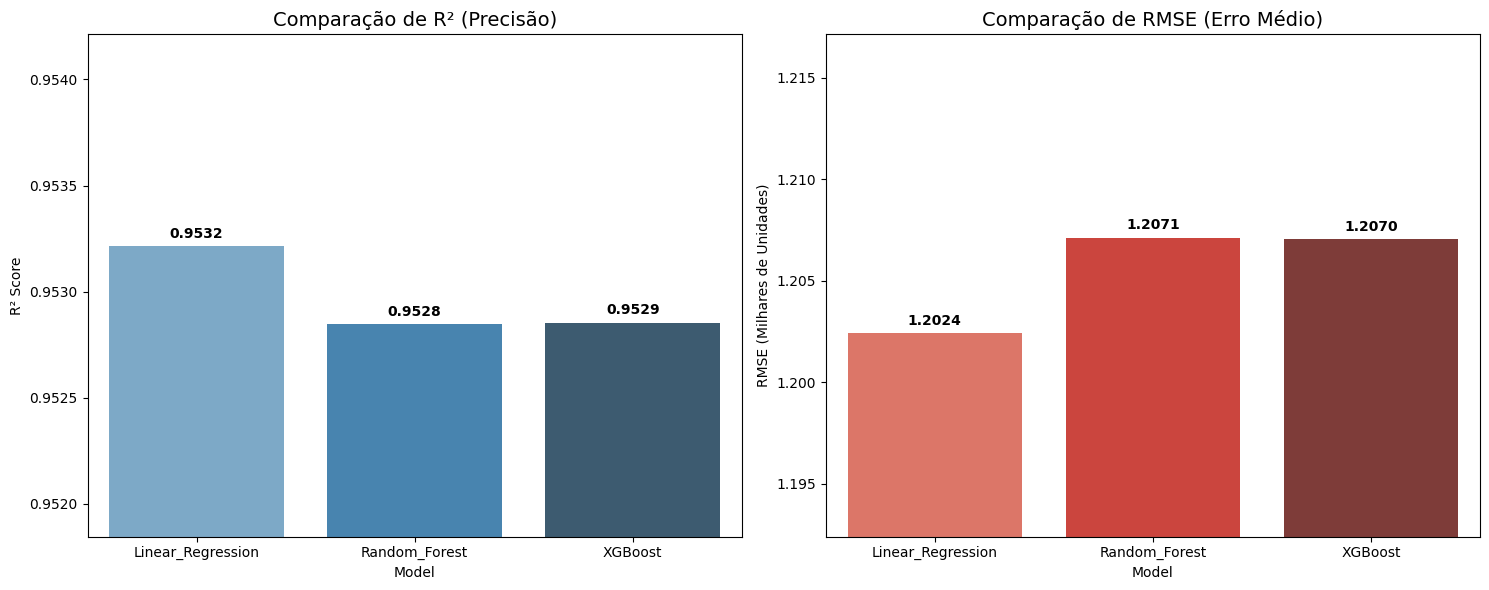

In [38]:
for name, pipeline in pipelines.items():
    grid = GridSearchCV(pipeline, params[name], cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {
        'Best Params': grid.best_params_,
        'R2 Score': r2,
        'RMSE': rmse,
        'Best Model': best_model
    }

comparison_df = pd.DataFrame(results).T[['R2 Score', 'RMSE']]

df_plot = comparison_df.reset_index().rename(columns={'index': 'Model'})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x='Model', y='R2 Score', data=df_plot, ax=ax1, palette='Blues_d')
ax1.set_title('Comparação de R² (Precisão)', fontsize=14)
ax1.set_ylabel('R² Score')
ax1.set_ylim(df_plot['R2 Score'].min() - 0.001, df_plot['R2 Score'].max() + 0.001)

sns.barplot(x='Model', y='RMSE', data=df_plot, ax=ax2, palette='Reds_d')
ax2.set_title('Comparação de RMSE (Erro Médio)', fontsize=14)
ax2.set_ylabel('RMSE (Milhares de Unidades)')
ax2.set_ylim(df_plot['RMSE'].min() - 0.01, df_plot['RMSE'].max() + 0.01)

for ax in [ax1, ax2]:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

C:\Users\Carlos Eduardo\AppData\Local\Temp\ipykernel_18408\120757364.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impacto', y='Atributo', data=coeff_df, palette='viridis')


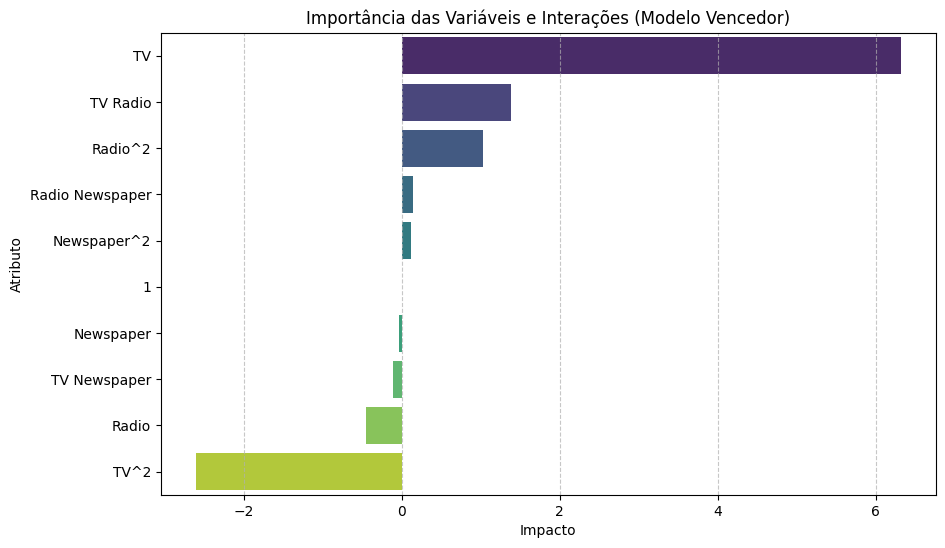

In [37]:
vencedor = results['Linear_Regression']['Best Model']

poly_transformer = vencedor.named_steps['poly']
feature_names = poly_transformer.get_feature_names_out(X.columns)

model_coeff = vencedor.named_steps['reg'].coef_

coeff_df = pd.DataFrame({'Atributo': feature_names, 'Impacto': model_coeff})
coeff_df = coeff_df.sort_values(by='Impacto', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Impacto', y='Atributo', data=coeff_df, palette='viridis')
plt.title('Importância das Variáveis e Interações (Modelo Vencedor)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### O Modelo Mais Promissor

Após a comparação, identificamos automaticamente o modelo com o menor $RMSE$ e maior $R^2$. Abaixo, extraímos os hiperparâmetros que foram selecionados pelo GridSearchCV como a configuração ideal para este problema.

In [ ]:
vencedor_nome = comparison_df['RMSE'].idxmin()
melhor_rmse = comparison_df.loc[vencedor_nome, 'RMSE']
melhor_r2 = comparison_df.loc[vencedor_nome, 'R2 Score']
hiperparametros_otimos = results[vencedor_nome]['Best Params']

print(f"--- RESULTADO FINAL DA COMPARAÇÃO ---")
print(f"Modelo mais promissor: {vencedor_nome}")
print(f"Melhor RMSE encontrado: {melhor_rmse:.4f}")
print(f"R2 Score correspondente: {melhor_r2:.4f}")
print(f"\nHiperparâmetros Identificados:")
for param, valor in hiperparametros_otimos.items():
    print(f"- {param}: {valor}")

--- RESULTADO FINAL DA COMPARAÇÃO ---
Modelo mais promissor: Linear_Regression
Melhor RMSE encontrado: 1.2024
R2 Score correspondente: 0.9532

Hiperparâmetros Identificados:
- reg__alpha: 0.1
